In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import chain, count, islice, cycle, combinations, product
from datetime import datetime, timedelta
import pickle
from tqdm.notebook import tqdm
from copy import deepcopy
import scipy.stats as sts

ModuleNotFoundError: No module named 'pycontractions'

# Upload data

In [2]:
data_dir = "/Users/amedvede/Google Drive/comptech_opinion_analizer/data_reddit/"
csv_file_list = [f for f in os.listdir(data_dir) if ".csv" in f]
csv_file_list

['JoeBiden_comments_2020_all.csv', 'Trump_comments_2020_all.csv']

In [3]:
biden_pd = pd.read_csv(os.path.join(data_dir, 'JoeBiden_comments_2020_all.csv'), index_col = 0)
trump_pd = pd.read_csv(os.path.join(data_dir, 'Trump_comments_2020_all.csv'), index_col = 0)

In [5]:
biden_pd

,author,body,created_utc,link_id,parent_id,score
0,progress18,https://www.youtube.com/watch?v=IRari6MZ3ek,1577836831,t3_ei9uvo,t3_ei9uvo,1
1,progress18,Don't forget to donate to Joe by midnight toni...,1577837169,t3_ei9uvo,t3_ei9uvo,1
2,AutoModerator,https://www.youtube.com/watch?v=IRari6MZ3ek\n\...,1577837170,t3_ei9uvo,t1_fcoo6nr,1
3,nightcloudsky,I feel like I am becoming one with universe ac...,1577837280,t3_eia4d6,t1_fcokn8b,1
4,PotGetsStirred,Thanks for reminding me to go donate a downvot...,1577837752,t3_ei9uvo,t3_ei9uvo,1
...,...,...,...,...,...,...
635391,flashmonkey26,I would say he would because it's his job and ...,1609460620,t3_knjjh6,t1_ghn8qdm,1
635392,pj7140,He is obviously under some misguided belief or...,1609460909,t3_knudsx,t1_ghno59b,1
635393,BenjaminKorr,The writer of this opinion said Pete came in 2...,1609461224,t3_knz449,t3_knz449,1
635394,LosinCash,I know. Just wished they were doing more out i...,1609461246,t3_ko18q1,t1_ghnohcp,1


# Few descriptive plots

In [10]:
biden_comment_dt, biden_comment_body = biden_pd.created_utc.to_list(), biden_pd.body.to_list()

In [11]:
time_bins = np.arange(min(biden_comment_dt), max(biden_comment_dt), 7*24*3600)
biden_counts, _, _, = sts.binned_statistic(biden_comment_dt, biden_comment_body, statistic = "count", bins = time_bins)

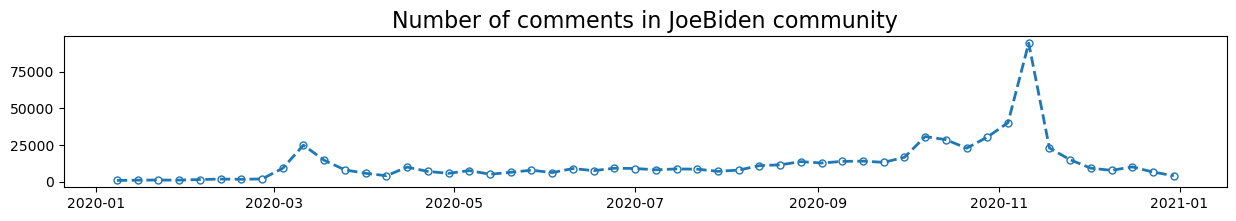

In [12]:
dt_bins = [datetime.fromtimestamp(t) for t in time_bins[1:]]

plt.figure(figsize = (15,2), dpi = 100)
plt.title("Number of comments in JoeBiden community", fontsize = 16)
plt.plot(dt_bins, biden_counts, lw = 2, ls = "--", marker = "o", markersize = 5, fillstyle = "none", )
plt.show()

In [6]:
trump_comment_dt, trump_comment_body = trump_pd.created_utc.to_list(), trump_pd.body.to_list()

In [7]:
trump_time_bins = np.arange(min(trump_comment_dt), max(trump_comment_dt), 7*24*3600)
trump_counts, _, _, = sts.binned_statistic(trump_comment_dt, trump_comment_body, 
                                           statistic = "count", bins = trump_time_bins)

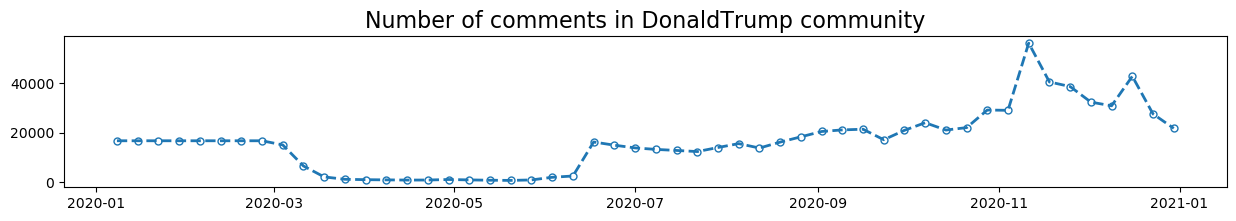

In [13]:
trump_dt_bins = [datetime.fromtimestamp(t) for t in trump_time_bins[1:]]

plt.figure(figsize = (15,2), dpi = 100)
plt.title("Number of comments in DonaldTrump community", fontsize = 16)
plt.plot(trump_dt_bins, trump_counts, lw = 2, ls = "--", marker = "o", markersize = 5, fillstyle = "none")
plt.show()

In [20]:
# JACCARD SIMILARITY SETS 
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(list2))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

authors_biden = biden_pd.author.unique()
authors_trump = trump_pd.author.unique()
J = jaccard_similarity(authors_biden, authors_trump)

print(f"Jaccard similarity of two author sets : {round(J,3)}")
print(f"Some authors participate in both discussions!!")

Jaccard similarity of two author sets : 0.041
Some authors participate in both discussions!!


# PREPROCESSING

In [4]:
target_pd = trump_pd

# Delete non-string comments

In [5]:
def remove_non_string_comments(input_pd, limit_rows = None):
    index_to_delete = []
    for index_row, row in tqdm(input_pd.iterrows(), total = len(input_pd)):
        comment = row.body
        if isinstance(comment, float):
            index_to_delete.append(index_row)
        if limit_rows is not None:
            if index_row > limit_rows:
                break
    new_pd = input_pd.drop(index = index_to_delete)
    new_pd.reset_index(inplace = True, drop = True)
    return new_pd

In [6]:
biden_pd = remove_non_string_comments(target_pd)

# Delete http links from comments

In [7]:
import re 
def find_http_in_string(string): 
    # VARIOUS REGULAR EXPRESSIONS WERE TESTED
#     regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    regex = r'(https?://[^\s]+)'
    url = re.findall(regex, string) 
    return url 

test_url= "My Profile: https://www.youtube.com/watch?v https://www.youtube.com/watch?v"
find_http_in_string(test_url)

['https://www.youtube.com/watch?v', 'https://www.youtube.com/watch?v']

In [8]:
# ERASE ALL HTTPS FROM COMMENTS
def clear_from_http(x):
    if not len(x):
        return x
    else:
        urls_found = find_http_in_string(x)
        if len(urls_found):
            for url in urls_found:
                x = x.replace(url, '')
        return x
    
target_pd["body"] = target_pd["body"].apply(clear_from_http)

# DELETE ALL USER AND SUBREDDIT MENTIONS

In [9]:
# ERASE ALL USER AND SUBREDDIT MENTIONS FROM COMMENTS
def find_mentions(string):
    regex = "(u/[^\s]+|r/[^\s]+)"
    mentions = re.findall(regex, string) 
    return mentions

def clear_from_mentions(x):
    if not len(x):
        return x
    else:
        mentions_found = find_mentions(x)
        if len(mentions_found):
            for mention in mentions_found:
                x = x.replace(mention, '')
        return x
    
target_pd["body"] = target_pd["body"].apply(clear_from_mentions)

# DELETE QUOTES FROM BODY

In [10]:
def find_quotes(string):
    regex = r"(&gt;[^\n]+)"
    mentions = re.findall(regex, string) 
    return mentions

def clear_from_quotes(x):
    if not len(x):
        return x
    else:
        quotes_found = find_quotes(x)
        if len(quotes_found):
            for quote in quotes_found:
                x = x.replace(quote, '')
        return x
    
target_pd["body"] = target_pd["body"].apply(clear_from_quotes)

# ERASE EMOJIS FROM TEXT

In [11]:
# ERASE ALL EMOJIS FROM COMMENTS
import demoji
def erase_emojis(text):
    if len(text):
        return demoji.replace(text)
    else:
        return text

target_pd["body"] = target_pd["body"].apply(erase_emojis)

# REMOVE DUPLICATES

In [12]:
target_pd.drop_duplicates(subset = ["body", "author", "link_id"], keep = "first", inplace = True, 
                                ignore_index = True)

# MESSAGES FROM BOTS OR MODS

In [46]:
author_bot_list = ["AutoModerator", "BotForceOne", "MemeWarriors", "ProdigalPlaneswalker" ]
bot_mod_indices = target_pd[target_pd.author.isin(author_bot_list)].index.to_list()
if len(bot_mod_indices):
    target_pd.drop(labels = author_bot_list, axis = 0, inplace = True)
    target_pd.reset_index(inplace = True, drop = True)

# REMOVE PUNCTUATION SHIT

In [47]:
def remove_puntuation_shit(s):
    # REMOVE CONSECUTIVE \n\n SYMBOLS
    s = s.replace("\n\n", " ")
    # REMOVE ALL SINGLE \n SYMBOLS
    s = s.replace("\n", "")

    # REMOVE ALL MULTIPLE WHITESPACES
    while True:
        s_next = s.replace("  ", " ")
        if s_next == s:
            break
        else:
            s = s_next
    return s

target_pd["body"] = target_pd["body"].apply(remove_puntuation_shit)

# DELETE COMMENTS WITH NO BODY, LESS THAN 5 WORDS, ONLY NON-LETTER CHARACTERS, ETC

In [49]:
indices_to_remove = []
for index, row in tqdm(target_pd.iterrows(), total = len(target_pd)):
    body = row.body.strip()
    if not len(body):
        indices_to_remove.append(index)
        continue
    if "**The following is an automated message:**" in body:
        indices_to_remove.append(index)
        continue
    split_body = body.split(" ")
    if len(split_body) <= 5:
        indices_to_remove.append(index)
        continue
        
target_pd.drop(labels = indices_to_remove, axis = 0, inplace = True)
target_pd.reset_index(inplace = True, drop = True)

In [50]:
len(target_pd), len(trump_pd)

(618861, 618861)

# SAVE THE MODIFIED DATAFRAME

In [51]:
out_data_dir = "/Users/amedvede/Google Drive/comptech_opinion_analizer/data_reddit_clean/"
os.makedirs(out_data_dir, exist_ok = True)

# CHECK THE NAME OF THE FILE TO MATCH THE DATAFRAME
target_pd.to_csv(os.path.join(out_data_dir, "Trump_comments_2020_clean.csv"))

# SANDBOX

In [36]:
# GET DUPLICATE COMMENTS 
duplicate_body = target_pd.duplicated(subset = ["body", "author"], keep = False)

In [37]:
duplicates_pd = target_pd[duplicate_body]
duplicates_pd

,author,body,created_utc,link_id,parent_id,score
154,webthing01,,1577840568,t3_eiajc1,t1_fcoptvb,1.0
187,littleirishmaid,LOL,1577844029,t3_eiaufj,t1_fcot48k,1.0
232,littleirishmaid,,1577844243,t3_eiaswy,t1_fcou6dn,1.0
302,Muh_Wailing_MXbabies,#,1577847719,t3_eiczcz,t1_fcp1j3i,1.0
350,Usuqamadiq,,1577847893,t3_ei8jmz,t1_fcos0c1,1.0
...,...,...,...,...,...,...
781960,DBLUSAFVET,Crickets,1609453578,t3_knsw4g,t1_ghmtrf9,1.0
782038,DBLUSAFVET,,1609455291,t3_knvutt,t1_ghn8992,1.0
782043,Redditthedog,yes,1609455383,t3_knydjc,t1_ghng24r,2.0
782069,Gtroxel4,,1609455680,t3_knsj1f,t1_ghmrsle,1.0


In [21]:
unique_authors = duplicates_pd.author.unique()

In [23]:
unique_authors[:100]

array(['AutoModerator', 'webthing01', 'littleirishmaid',
       'Muh_Wailing_MXbabies', 'Usuqamadiq', 'ENVYNITAZ', 'GirlsGoneMAGA',
       'iRubGuacOnMyArmpits', 'JesusIsMySavior0001', 'josemsm80',
       'miltonf314', 'Beepboopcomrad', 'catsfive', 'Sgt_Thundercok',
       'Sususu77', 'UsernameNeo', 'Forgototherpassword', 'thenew23rd',
       'cgaengineer', 'yelloWhit', 'WheeeeeThePeople',
       'I-am-a-cardboard-box', 'semlaw', 'Sunfloweragain6873',
       'Razzle_Dazzle08', 'BotForceOne', 'DiamondsOnTheFloor',
       'JohnnyBitcoinCash', 'Nikovelli', 'thenotoriousdougie',
       'SAW2TH-55th', 'barbief', 'JoesWhiteLegHair', 'Jabblemonkey',
       'Sea_Still', 'MurrayFranklinRIP', 'SirSeizureSalad',
       'Tantalus4200', 'Oughthere', 'xiao_ke_maga', 'Disquestrian',
       'dougkeenan', 'basedBlumpkin', 'Toughduck48', 'rprobens',
       'TurdCrapily', 'StartingOver095', 'vv33cl', 'spicy_kek', 'Le_Pew',
       'MAGA-Lady-Ok', 'tempthrowawaydiner', 'knightofday87',
       'RuleoVicus',

In [19]:
# modify the output option to see more rows
pd.set_option('display.max_rows', 500)
duplicates_pd[duplicates_pd.author.isin(["BotForceOne", "AutoModerator"])]

,author,body,created_utc,link_id,parent_id,score
15,AutoModerator,**OFFICIAL THE DONALD BACKUP: \n\n---\...,1577836853,t3_eib0cg,t3_eib0cg,1.0
28,AutoModerator,**OFFICIAL THE DONALD BACKUP: \n\n---\...,1577836901,t3_eib0q3,t3_eib0q3,1.0
33,AutoModerator,**OFFICIAL THE DONALD BACKUP: \n\n---\...,1577836913,t3_eib0ta,t3_eib0ta,1.0
69,AutoModerator,**OFFICIAL THE DONALD BACKUP: \n\n---\...,1577837092,t3_eib27k,t3_eib27k,1.0
71,AutoModerator,**OFFICIAL THE DONALD BACKUP: \n\n---\...,1577837096,t3_eib28v,t3_eib28v,1.0
...,...,...,...,...,...,...
853494,AutoModerator,\n**★** [**Election Defense Task Force**](/ **...,1609456871,t3_ko0dx0,t3_ko0dx0,1.0
853524,AutoModerator,\n**★** [**Election Defense Task Force**](/ **...,1609457672,t3_ko0lv0,t3_ko0lv0,1.0
853559,AutoModerator,\n**★** [**Election Defense Task Force**](/ **...,1609458219,t3_ko0r5p,t3_ko0r5p,1.0
853565,AutoModerator,\n**★** [**Election Defense Task Force**](/ **...,1609458334,t3_ko0sbw,t3_ko0sbw,1.0


In [42]:
duplicates_pd[3400:3700]

,author,body,created_utc,link_id,parent_id,score
201627,ThePonzo,,1594137822,t3_hmbg8e,t1_fx78zme,1.0
201629,jamesgalb,**The following is an automated message:**\n\n...,1594137869,t3_hmxbq5,t3_hmxbq5,1.0
201647,ManateeRawr,**The following is an automated message:**\n\n...,1594138464,t3_hmxi53,t3_hmxi53,1.0
201655,Odani_cullah,,1594138703,t3_hmx847,t1_fx7tlzp,1.0
201689,Odani_cullah,,1594139660,t3_hmwiv5,t1_fx7tqxj,2.0
201812,StrokingBadger,Republican Speaker of the House Dennis Hastert...,1594143198,t3_hmsfgi,t1_fx805f1,0.0
201870,PatriotTruthSeeker,Good.,1594145227,t3_hmxez1,t3_hmxez1,1.0
201872,_Woodrow_,,1594145304,t3_hmuexz,t1_fx884ab,0.0
201878,magatracker,[Gateway Pundit](,1594145381,t3_hmzqvr,t3_hmzqvr,2.0
201957,Fancy-Button,,1594148120,t3_hmdc4y,t1_fx7zpm5,1.0


In [39]:
duplicates_pd.loc[160908].body

'**The following is an automated message:**\n\nYour post was reported by the  community members for not following these community and/or Reddit rule(s):\n\n- 2. Participate in Good Faith\n\n\n\nIn response, the moderators of  have removed your post. To get a better understanding of why your post was removed, [review the community rules](//about/rules) or [ask the moderators]( for clarification. Once you understand  rules, feel free to post again.'

In [116]:
SM = '🤗🤗🤗 here you go'
SM

'🤗🤗🤗 here you go'

In [117]:
demoji.replace(SM)

' here you go'

In [ ]:
re.findall(r'((\w)\2{2,})', s)

In [162]:
regex = r"(&gt;[^\n]+)"
re.findall(regex, text)

["&gt;Instead of 'fiscally conservative but socially liberal,' let's call the New Democrats and Blue Dog Caucus the 'New Southern Democrats.' They certainly seem hell bent to do to black and brown people today what the old Southern Democrats did the 40s"]

In [141]:
regex = r'([^\s]+)'
re.findall(regex, "hshshs")

['hshshs']

In [144]:
reply_pd = biden_no_nan_pd[biden_no_nan_pd.body.str.contains("&gt;")]


In [160]:
text = reply_pd.iloc[20].body
text

"It was a while back. Basically, he tweeted \n\n&gt;Instead of 'fiscally conservative but socially liberal,' let's call the New Democrats and Blue Dog Caucus the 'New Southern Democrats.' They certainly seem hell bent to do to black and brown people today what the old Southern Democrats did the 40s\n\nWhich a lot of people (including myself) saw as saying I'd you're a centrists, you're a rascist."

In [161]:
len(reply_pd)

12537

In [24]:
# REMOVE HTTPS
new_body_list = remove_http_links_from_body(biden_no_nan_pd)

# GENERATE A NEW DATAFRAME FROM IT
biden_no_http_pd.drop(columns = ["body"], inplace = True)
new_body_pd = pd.DataFrame({"body": new_body_list})
biden_no_http_pd = pd.concat([biden_no_nan_pd, new_body_pd], axis=1)
biden_no_http_pd.head()

NameError: name 'biden_no_http_pd' is not defined